In [1]:
import os
import ctypes

# 🔐 Add CUDA DLL path for TensorFlow to load GPU libraries correctly on Windows
cuda_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin"
os.add_dll_directory(cuda_path)

# ✅ Attempt to load a core CUDA DLL manually (to verify it's accessible)
try:
    ctypes.WinDLL(os.path.join(cuda_path, "cudart64_110.dll"))
    print("✅ cudart64_110.dll loaded manually")
except Exception as e:
    print("❌ Failed to load cudart64_110.dll:", e)

import tensorflow as tf
tf.keras.backend.clear_session()



✅ cudart64_110.dll loaded manually


## 1) Preprocessing

In [2]:
import pandas as pd

# 100 rows is just for testing
dataset = pd.read_excel('./data/data.xlsx', nrows=100000)
english_sentences, dutch_sentences = dataset['English'].astype(str), dataset['Dutch'].astype(str)


For during training we first need to preprocess the sentences for better performance. I found out dat you need to add a start and end token to the target language sentences. This so that the model can know when to start a translation and when to end it so it never creates a sentence to long or to short.

```python
Input: "Hello, how are you?"
Target: "<start> Hallo, hoe gaat het? <end>"
```

In [3]:
def preprocess_input_sentence(sentence: str) -> str:
    return sentence.lower().strip()

def preprocess_target_sentence(sentence: str) -> str:
    return f"<start> {sentence.lower().strip()} <end>"

english_sentences = english_sentences.apply(preprocess_input_sentence)
dutch_sentences = dutch_sentences.apply(preprocess_target_sentence)

## 2) Tokenization and Padding

The model has an input layer which expects a certain amount of inputs. But not all sentences are the same lenght. So padding needs to be added to the sentences and some sentences need to be cropped.

In [4]:
from typing import List
from tensorflow.keras.layers import TextVectorization
from tensorflow.strings import lower, regex_replace

MAX_VOCABULARY_SIZE = 15000
MAX_SEQUENCE_LENGTH = 35

def custom_standardization(input_text):
    # Lowercase and remove punctuation, but keep <start> and <end>
    lowercase = lower(input_text)
    return regex_replace(lowercase, r"[^\w\s<>]", "")

def tokenize_and_pad(sentences: List[str], max_len=MAX_SEQUENCE_LENGTH):
    vectorizer = TextVectorization(
        max_tokens=MAX_VOCABULARY_SIZE,
        output_mode='int',
        output_sequence_length=max_len,
        standardize=custom_standardization)
    
    vectorizer.adapt(sentences)
    return vectorizer(sentences), vectorizer

encoder_input_data, eng_vectorizer = tokenize_and_pad(english_sentences)
decoder_sequences, dut_vectorizer = tokenize_and_pad(dutch_sentences)


In [5]:
import numpy as np

decoder_input_data = decoder_sequences[:, :-1]
decoder_target_data = decoder_sequences[:, 1:]

**Why this shift is necessary:**

During training, the decoder works as follows:
1. Decoder input: Starting with `<start>` token and containing all words except the `<end>` token. This way, the decoder will never need to predict the `<end>` token as an input.

2. Decoder target: Contains all the words plus the `<end>` token, but excludes the <start> token. This ensures the model never tries to predict <start> as an output.

This shift properly aligns the input-target pairs for teacher forcing during training, where each token in the input helps predict the next token in the target translation. The model learns to generate each word based on previously generated words, and finally to generate the <end> token to properly stop the futher translation.

## 3) Creating the encoder

The slides contained certain classes which can not be imported from keras. The slides did not mention these but i got this code from the books repository `Deeplearning with python second edition.` 

In [6]:
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow as tf

# The total amount of dimensions the wods can have. The more dimensions the more complex realtions words can have.
EMBEDDING_DIMENSIONS = 256
FF_DIM = 256
DROPOUT = 0.1
NUM_HEADS = 4

vocab_size_input = len(eng_vectorizer.get_vocabulary())
vocab_size_target = len(dut_vectorizer.get_vocabulary())

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length

    def call(self, x):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        positions = self.pos_emb(positions)
        positions = positions[:tf.shape(x)[1]] 
        x = self.token_emb(x)
        return x + positions

# Transformer Encoder Block
def transformer_encoder(inputs, num_layers=4):
    x = inputs
    for _ in range(num_layers):
        x_res = LayerNormalization(epsilon=1e-6)(x)
        attention_output = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_DIMENSIONS)(x_res, x_res)
        x = Dropout(DROPOUT)(attention_output + x)
        x_res = LayerNormalization(epsilon=1e-6)(x)
        ffn_output = Dense(FF_DIM, activation="relu")(x_res)
        ffn_output = Dense(EMBEDDING_DIMENSIONS)(ffn_output)
        x = Dropout(DROPOUT)(ffn_output + x)
    return x

# Transformer Decoder Block
def transformer_decoder(x, encoder_output):
    # Self-attention with residual + LayerNorm
    x_res = x
    attn1 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_DIMENSIONS)(x, x)
    x = Dropout(DROPOUT)(attn1 + x_res)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Cross-attention (encoder-decoder) with residual + LayerNorm
    x_res = x
    attn2 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_DIMENSIONS)(x, encoder_output)
    x = Dropout(DROPOUT)(attn2 + x_res)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network with residual + LayerNorm
    x_res = x
    ffn_output = Dense(FF_DIM, activation="relu")(x)
    ffn_output = Dense(EMBEDDING_DIMENSIONS)(ffn_output)
    x = Dropout(DROPOUT)(ffn_output + x_res)
    x = LayerNormalization(epsilon=1e-6)(x)

    return x


In [7]:



encoder_input = Input(name="encoder_input_layer", shape=(None,))
x = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size_input, EMBEDDING_DIMENSIONS)(encoder_input)
x = Dropout(0.1)(x)
enc_out = transformer_encoder(x)

## 4) Creating the decoder

In [8]:
decoder_input = Input(name="decoder_input_layer", shape=(None,))
dec_emb = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size_target, EMBEDDING_DIMENSIONS)(decoder_input)
dec_out = transformer_decoder(dec_emb, enc_out)

outputs = Dense(vocab_size_target, activation="softmax")(dec_out)

In [9]:
transformer_model = Model([encoder_input, decoder_input], outputs, name="transformer_model")
transformer_model.summary()

Model: "transformer_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, None)]      0           []                               
 r)                                                                                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   390144      ['encoder_input_layer[0][0]']    
 alEmbedding)                                                                                     
                                                                                                  
 dropout (Dropout)              (None, None, 256)    0           ['positional_embedding[0][0]']   
                                                                                  

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

transformer_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


## 5) Training the model

Before the model can be trained the training set first needs to be created.

In [11]:
from tensorflow.data import Dataset, AUTOTUNE

targets = np.expand_dims(np.array(decoder_target_data), -1)

dataset = Dataset.from_tensor_slices((encoder_input_data, decoder_input_data, targets))

def format(encoder_input, decoder_input, decoder_target):
    return (encoder_input, decoder_input), decoder_target

dataset = dataset.map(format).shuffle(1024).batch(64).prefetch(AUTOTUNE)

# Split dataset: 80% train, 20% validation (by batches)
total_batches = len(dataset)
train_size = int(0.8 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
]

history = transformer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)



Epoch 1/25
1250/1250 [==============================] - 95s 71ms/step - loss: 1.1124 - accuracy: 0.8279 - val_loss: 0.1112 - val_accuracy: 0.9833
Epoch 2/25
1250/1250 [==============================] - 86s 69ms/step - loss: 0.1062 - accuracy: 0.9872 - val_loss: 0.0208 - val_accuracy: 0.9971
Epoch 3/25
1250/1250 [==============================] - 86s 69ms/step - loss: 0.0300 - accuracy: 0.9969 - val_loss: 0.0089 - val_accuracy: 0.9986
Epoch 4/25
1250/1250 [==============================] - 86s 69ms/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.0050 - val_accuracy: 0.9992
Epoch 5/25
1250/1250 [==============================] - 87s 69ms/step - loss: 0.0075 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 6/25
1250/1250 [==============================] - 87s 70ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 7/25
1250/1250 [==============================] - 87s 69ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0014 -

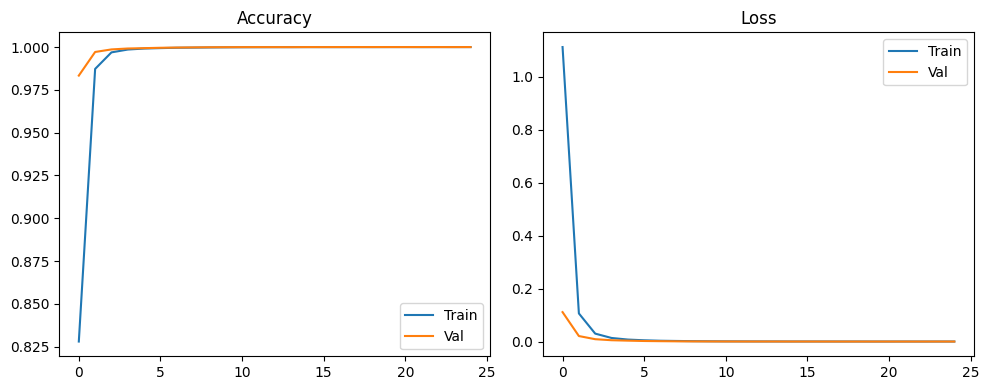

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss"); plt.legend()
plt.tight_layout()
plt.show()

Note: Despite training, the Transformer seems to have underfit. This might be due to insufficient data, lack of regularization, or inadequate training steps.

## 6) Translating a sentence

In [14]:
from typing import Tuple

word_index = dict(enumerate(dut_vectorizer.get_vocabulary()))  # same thing but okay



def translate(sentence: str) -> str:
    sentence = preprocess_input_sentence(sentence)
    input_sequence = eng_vectorizer([sentence])

    start_token_id = dut_vectorizer("<start>").numpy()[0]
    end_token_id = dut_vectorizer("<end>").numpy()[0]

    decoder_input = tf.expand_dims([start_token_id], 0)

    translated_tokens = []

    def get_highest_prediction(predictions: Tuple) -> int:
        # predictions = (batch, time, vocab_size)
        return np.argmax(predictions[0, -1, :])
    
    def get_translated_word(word_id: int) -> str:
        return word_index.get(word_id, "?")


    for _ in range(MAX_SEQUENCE_LENGTH):
        predictions = transformer_model.predict([input_sequence, decoder_input], verbose=0)

        next_word_id = get_highest_prediction(predictions)

        # Check if the next word is the <end> token if so stop translation.
        if next_word_id == end_token_id:
            break;
        
        next_word = get_translated_word(next_word_id)

        translated_tokens.append(next_word)
        decoder_input = tf.concat([decoder_input, [[next_word_id]]], axis=-1)

    return " ".join(translated_tokens).capitalize() + "."



## 7) Analysis of Model Performance

### Common Issues Observed:
1. **Token Repetition**
   - The RNN model shows the same word patterns
   - This likely means the model is getting stuck in certain patterns
   - Likely due to the lack of attention mechanism

2. **Grammar and Structure**
   - The model doesn't maintain proper Dutch sentence structure
   - Word order is often incorrect
   - Missing or incorrect articles and prepositions

3. **Meaning Preservation**
   - Translations often lose the original meaning
   - The model generates plausible Dutch words but in incorrect contexts
   - This indicates the model hasn't learned the semantic relationships well

### Potential Causes:
1. **Training Data Issues**
   - Limited training data (50,000 samples)
   - Possible data quality issues in preprocessing
   - Imbalanced distribution of sentence lengths

2. **Model Architecture**
   - Lack of attention mechanism
   - Single LSTM layer might not be sufficient
   - Embedding dimensions might need adjustment

3. **Training Process**
   - Learning rate might need tuning
   - Training might need more epochs
   - Early stopping might be too aggressive

### What i would improve next:
1. **Data**
   - Improve preprocessing
   - Balance sentence length distribution

2. **Model Architecture**
   - Add attention mechanism
   - Increase LSTM layers
   - Adjust embedding dimensions

3. **Training**
   - Increase training epochs
   - Add validation metrics

In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

def calculate_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
test_pairs = [
    ("Hello, how are you?", "Hallo, hoe gaat het met je?"),
    ("This is my house.", "Dit is mijn huis."),
    ("Thank you for the help.", "Bedankt voor de hulp."),
    ("We are going to the beach.", "We gaan naar het strand."),
    ("I like to read books.", "Ik lees graag boeken.")
]

transformer_scores = []
for eng, dutch in test_pairs:
    transformer_translation = translate(eng)  # Using our existing translate function
    transformer_scores.append(calculate_bleu(dutch, transformer_translation))

print(f"Average BLEU Score: {sum(transformer_scores)/len(transformer_scores):.4f}")

print("\nDetailed Results:")
for i, (eng, dutch) in enumerate(test_pairs):
    print(f"\n{i+1}. {eng}")
    print(f"   Expected: {dutch}")
    print(f"   Transformer: {translate(eng)}")
    print(f"   BLEU Score: {transformer_scores[i]:.4f}")

Average BLEU Score: 0.0000

Detailed Results:

1. Hello, how are you?
   Expected: Hallo, hoe gaat het met je?
   Transformer: Maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar.
   BLEU Score: 0.0000

2. This is my house.
   Expected: Dit is mijn huis.
   Transformer: Maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar.
   BLEU Score: 0.0000

3. Thank you for the help.
   Expected: Bedankt voor de hulp.
   Transformer: Maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar maar.
   BLEU Score: 0.0000

4. We are going to the beach.
   Expected: We gaan naar het strand.
   Transformer: Maar maar maar maar maar maar maar maar maar m